<a href="https://colab.research.google.com/github/LeonardoGoncRibeiro/03_StatisticsUsingPython/blob/main/06_LinearRegression_TestingAndPredicting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistics Using Python: Linear Regression - Test and prediction

In this course, we will learn more about linear regression. First, we will import a dataset, and visualize some of our features. We will learn what is the difference between dependent and independent (or explicative) variables. Then, we will separe our dataset into train and test data. Finally, we will fit linear regression models, understand which metrics can be used to compare such models, and choose which are the best models.

First, we will import some basic libraries:

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

Here, we will use a dataset from Kaggle related to the beer consumption in São Paulo in each day. We also have the minimum, maximum, and average temperature, the precipitation, and a boolean that shows if the day is a weekend or not. So, let's import our dataset:

In [98]:
beer = pd.read_csv('Consumo_cerveja.csv', sep = ';')
beer

,data,temp_media,temp_min,temp_max,chuva,fds,consumo
0,01/01/2015,27.30,23.9,32.5,0.0,0,25461
1,02/01/2015,27.02,24.5,33.5,0.0,0,28972
2,03/01/2015,24.82,22.4,29.9,0.0,1,30814
3,04/01/2015,23.98,21.5,28.6,1.2,1,29799
4,05/01/2015,23.82,21.0,28.3,0.0,0,28900
...,...,...,...,...,...,...,...
360,27/12/2015,24.00,21.1,28.2,13.6,1,32307
361,28/12/2015,22.64,21.1,26.7,0.0,0,26095
362,29/12/2015,21.68,20.3,24.1,10.3,0,22309
363,30/12/2015,21.38,19.3,22.4,6.3,0,20467


First, let's turn the date columns into a datetime, and them let's sort data based on this feature.

In [99]:
beer.data = pd.to_datetime(beer.data)
beer.sort_values('data', inplace = True)
beer.reset_index(drop = True, inplace = True)

Let's verify the size of our dataset:

In [100]:
beer.shape

(365, 7)

We have 365 entries and 7 columns.

## Preliminary analysis

Before going further into our regression models, we will perform some preliminary analyses. First, let's see some descriptive statistics.

In [101]:
beer.describe( )

,temp_media,temp_min,temp_max,chuva,fds,consumo
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,21.226356,17.461370,26.611507,5.196712,0.284932,25401.367123
std,3.180108,2.826185,4.317366,12.417844,0.452001,4399.142703
min,12.900000,10.600000,14.500000,0.000000,0.000000,14343.000000
25%,19.020000,15.300000,23.800000,0.000000,0.000000,22008.000000
50%,21.380000,17.900000,26.900000,0.000000,0.000000,24867.000000
75%,23.280000,19.600000,29.400000,3.200000,1.000000,28631.000000
max,28.860000,24.500000,36.500000,94.800000,1.000000,37937.000000


Here, we can see the minimum and maximum values of each variable, as well as the mean, standard deviation, and quartiles. Usually, we are able to note if there is any strange variables looking at this table. However, that does not seem to be the case here.

Now, let's get the correlation matrix. The correlation matrix allows us to see if there is a linear association between two variables:

In [102]:
beer.corr( )

,temp_media,temp_min,temp_max,chuva,fds,consumo
temp_media,1.000000,0.862752,0.922513,0.024416,-0.050803,0.574615
temp_min,0.862752,1.000000,0.672929,0.098625,-0.059534,0.392509
temp_max,0.922513,0.672929,1.000000,-0.049305,-0.040258,0.642672
chuva,0.024416,0.098625,-0.049305,1.000000,0.001587,-0.193784
fds,-0.050803,-0.059534,-0.040258,0.001587,1.000000,0.505981
consumo,0.574615,0.392509,0.642672,-0.193784,0.505981,1.000000


Note that the correlation between the maximum temperature and the beer consumption is very high ($0.64$). Looking at the average and minimum temperature we can also see a positive linear association.

However, precipitation shows a negative association. That means that, as precipitation increases, the beer consumption actually decreases!

Note that we can also see that there is a very high correlation between average, minimum, and maximum temperatura. We should not use these variables in the same model, since they seem to be very well correlated. That follows the intuition: if the maximum temperature increases, so does the average temperature, for instance.

# Behavior of the dependent variable

Now, let's study more about the behavior of the dependent variable. First, let's plot the variable as a time series:

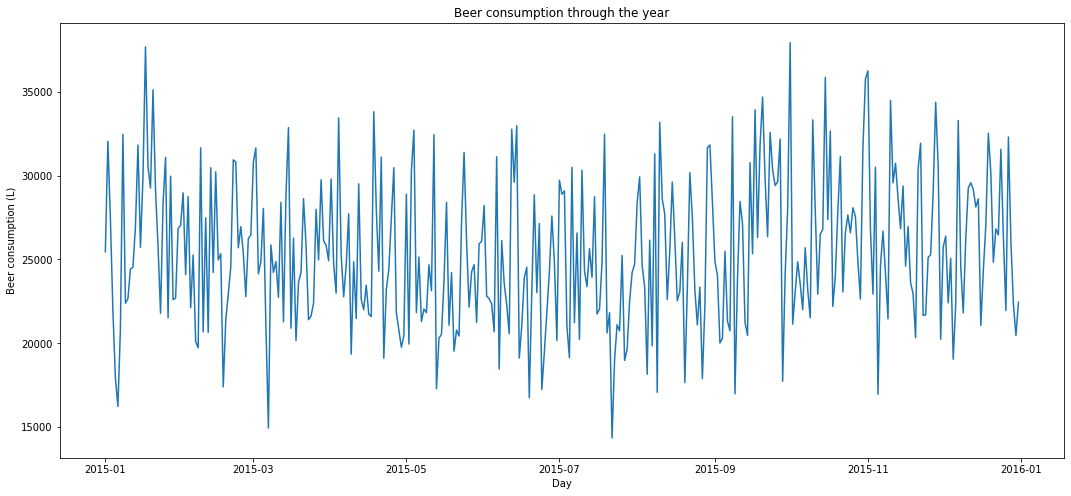

In [103]:
fig, ax = plt.subplots(figsize = (18, 8))

ax.set_title('Beer consumption through the year')
ax.set_xlabel('Day')
ax.set_ylabel('Beer consumption (L)')

ax = plt.plot(beer.data, beer.consumo)

Note that the beer consumption varies a lot. We note that there is a trend of decreasing the consumption and, after, the beer consumption increases again. However, our data seem to have a strong sazonality effect (or maybe even noise).

Now, let's use a boxplot:

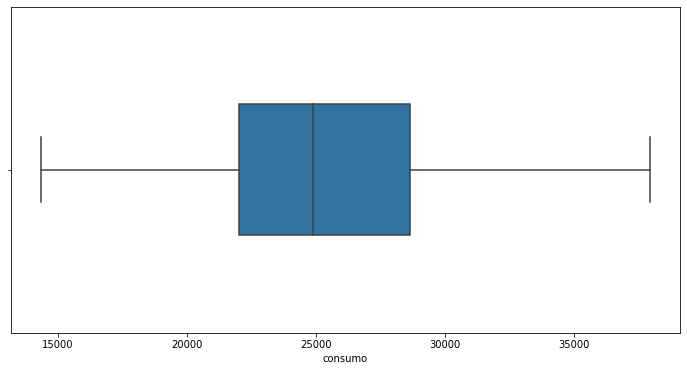

In [104]:
ax = sns.boxplot(x = 'consumo', data = beer, width = 0.4)
ax.figure.set_size_inches(12, 6)

We can't see an unusual pattern in the data. We can't find any outliers in this data (according to the defaul method for outlier detection).

Ok. Now, how can we understand if there is a relationship between beer consumption and other variables using a boxplot?

We can do that by passing other parameter:

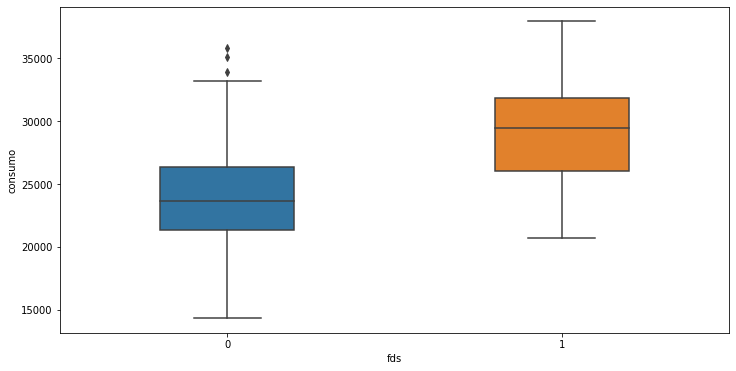

In [105]:
ax = sns.boxplot(x = 'fds', y = 'consumo', data = beer, width = 0.4)
ax.figure.set_size_inches(12, 6)

We see that, if it is a weekend (fds = 1), the beer consumption is much higher! We also see some outliers in the boxplot for fds = 0. This could be, for instance, due to holidays.

Finally, let's draw a histogram for our dependent variable:

We see that the histogram for our dependent variable is very right skewed. Thus, it seems that the distribution does not follow a Normal. 

# Understanding the explicative variables

Now, we will delve further in trying to understand how the explicative (or independent) variables are related to the dependent variable.

First, let's make a pairplot. A pairplot allows us to see, in only one figure, how multiple variables are related to each other.

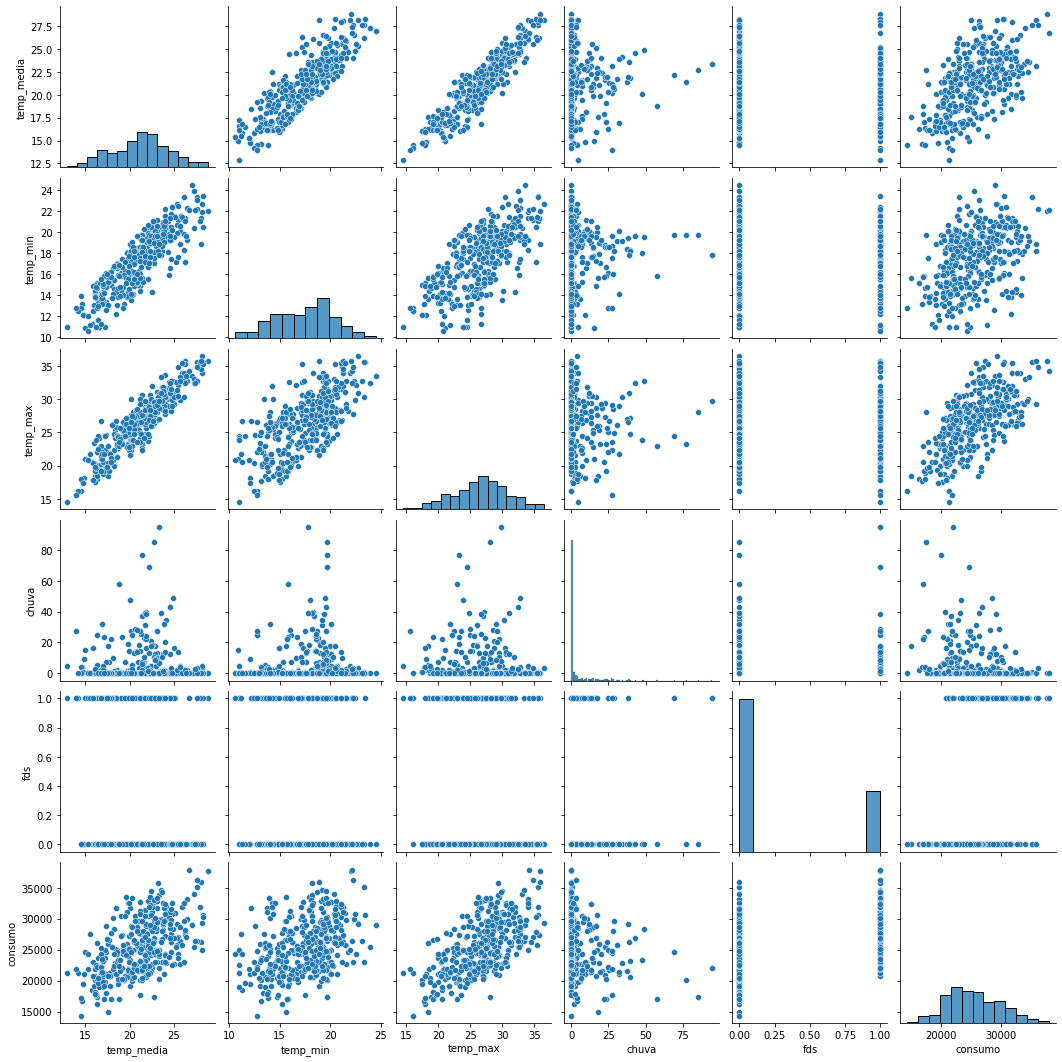

In [106]:
ax = sns.pairplot(beer)

Nice! Note that the pairplot is a very heavy graph. We can also only perform some scatter plots using:

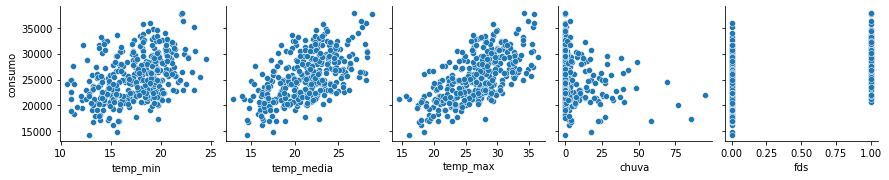

In [107]:
ax = sns.pairplot(beer, y_vars = ['consumo'], x_vars = ['temp_min', 'temp_media', 'temp_max', 'chuva', 'fds'])

We can also draw a regression line using the pairplot. To that end, we just have to use:

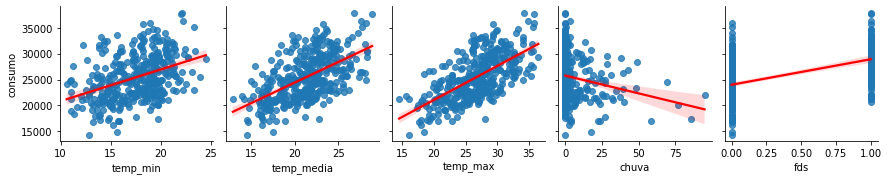

In [108]:
ax = sns.pairplot(beer, y_vars = ['consumo'], x_vars = ['temp_min', 'temp_media', 'temp_max', 'chuva', 'fds'], kind = 'reg', plot_kws={'line_kws':{'color':'red'}})

Another strong tool to allow us to see if there is a relation between variables is the joint plot:

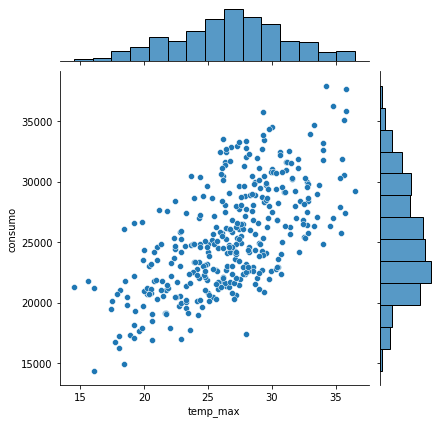

In [109]:
ax = sns.jointplot(x = 'temp_max', y = 'consumo', data = beer)

Here we see a scatter plot of the data, but we also see a histogram for each feature! Again, we can also draw a regression line using the jointplot:

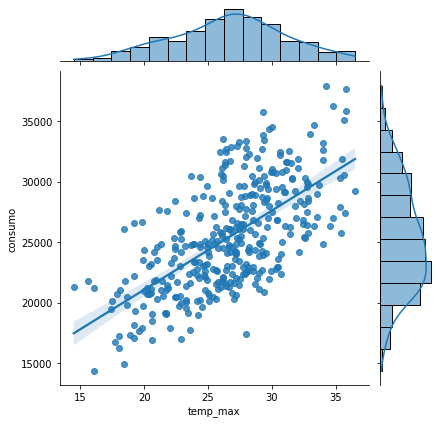

In [110]:
ax = sns.jointplot(x = 'temp_max', y = 'consumo', data = beer, kind = 'reg')

Finally, if we simply want to plot the scatter plot with the regression line we can simply use a *lmplot( )*:

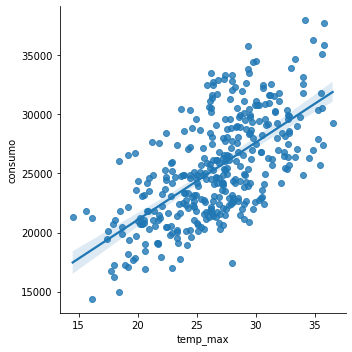

In [111]:
ax = sns.lmplot(x = 'temp_max', y = 'consumo', data = beer)

Here, we can also, for instance, add a new dependent variable considering the hue parameter:

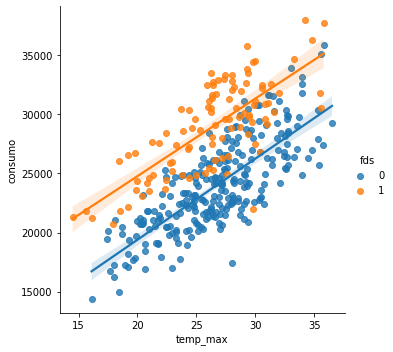

In [112]:
ax = sns.lmplot(x = 'temp_max', y = 'consumo', hue = 'fds', data = beer)

Here, it becomes very clear that the beer consumption is higher on the weekends. If we want to see these in separated graphs, we can use the col parameter:

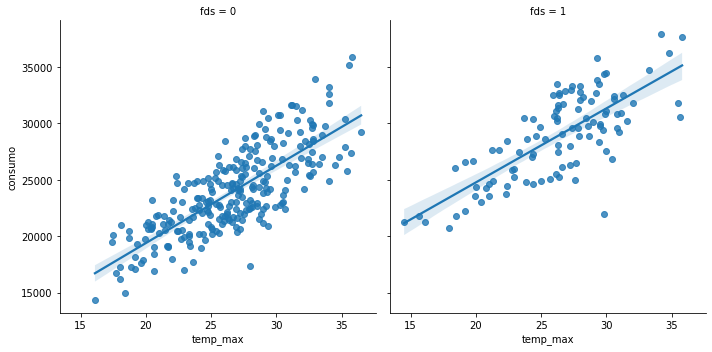

In [113]:
ax = sns.lmplot(x = 'temp_max', y = 'consumo', col = 'fds', data = beer)

More interesting graphs using the Seaborn package can be found in:

https://towardsdatascience.com/14-data-visualization-plots-of-seaborn-14a7bdd16cd7

# Linear Regression

Finally, here, we will fit a univariate linear regression model. The linear regression studies the linear association between variables. In this course, we will use the scikit-learn library to perform a linear regression.

Before fitting our model, we will use the scikit-learn library to define train and test sets. First, let's import our library:


In [114]:
from sklearn.model_selection import train_test_split

Our first model will use beer consumption as a dependent variable. So, first, let's separe it from the rest of the data:

In [115]:
y = beer.consumo
X = beer.drop('consumo', axis = 1)

In [116]:
y

0      25461
1      32057
2      27475
3      21979
4      17939
       ...  
360    32307
361    26095
362    22309
363    20467
364    22446
Name: consumo, Length: 365, dtype: int64

## Train-test split

Finally, let's make our train-test split:

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2811)

Here, 30% of our samples are going into the test sample, and 70% are going into the train sample. Let's check these samples:

In [118]:
X_train

,data,temp_media,temp_min,temp_max,chuva,fds
195,2015-07-15,20.18,17.2,27.6,0.0,0
344,2015-12-11,23.78,20.8,31.8,0.0,0
288,2015-10-16,26.24,21.3,35.7,0.0,0
59,2015-03-01,24.82,22.4,29.9,0.0,1
220,2015-08-09,17.08,15.8,19.2,23.6,0
...,...,...,...,...,...,...
73,2015-03-15,22.08,19.1,26.8,0.3,1
68,2015-03-10,20.28,16.1,25.0,25.0,1
215,2015-08-04,18.68,14.7,24.3,0.4,0
341,2015-12-08,20.12,14.1,26.6,0.0,0


In [119]:
y_train

195    28742
344    29267
288    27387
59     30814
220    17075
       ...  
73     32872
68     24876
215    23362
341    24594
84     27989
Name: consumo, Length: 255, dtype: int64

Note that both X_train and y_train have 255 observations, which is close to 70% of number of observations on the initial sample:

In [120]:
X_train.shape[0]/X.shape[0]

0.6986301369863014

The rest of the observations went to the test set:

In [121]:
X_test

,data,temp_media,temp_min,temp_max,chuva,fds
5,2015-01-06,16.28,15.2,18.0,2.2,0
83,2015-03-25,21.56,17.1,27.9,0.0,0
40,2015-02-10,24.74,19.3,32.7,0.0,0
143,2015-05-24,21.80,17.9,26.3,0.0,1
193,2015-07-13,22.06,16.7,28.7,0.0,0
...,...,...,...,...,...,...
46,2015-02-16,21.60,18.8,27.3,22.7,0
229,2015-08-18,21.30,16.7,26.5,0.0,0
45,2015-02-15,22.90,20.0,27.6,17.4,1
329,2015-11-26,22.28,19.0,27.4,0.0,0


In [122]:
y_test

5      16228
83     22401
40     27488
143    31387
193    25640
       ...  
46     25343
229    23070
45     24968
329    25285
203    19029
Name: consumo, Length: 110, dtype: int64

Which correspond to close to 30% of the number of observations:

In [123]:
X_test.shape[0]/X.shape[0]

0.3013698630136986

## Fitting the linear regression model

Now, we are going to fit a linear regression model. First, we will fit a model with three independent variables:

\begin{equation}
Y_i = \beta_1 + \beta_2 \, X_{2,i} + \beta_3 \, X_{3,i} + \beta_4 \, X_{4,i} + u_i
\end{equation}

As explicative variables, we will use:



*   Maximum temperature
*   Precipitation
*   Weekend (boolean)


So, let's import our libraries:

In [124]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

Now, let's create an object of the class LinearRegression:

In [125]:
model = LinearRegression( )

Finally, let's fit our model using the training data:

In [126]:
model.fit(X_train[['temp_max', 'chuva', 'fds']], y_train)

LinearRegression()

We can check how well our regression is fitted to the data using:

In [127]:
model.score(X_train[['temp_max', 'chuva', 'fds']], y_train).round(2)

0.74

Now that we have a model, we can make predictions using our model. Thus, we can do:

In [128]:
y_pred = model.predict(X_test[['temp_max', 'chuva', 'fds']])

Nice! Now, let's compare the predicted $y$ with the test set. For that end, we can use the coefficient of determination between the test and predicted sets:

In [129]:
metrics.r2_score(y_test, y_pred).round(2)

0.67

Nice! This shows that our prediction is well correlated with the test set. Now, let's try to make predictions outside of the test sample. Thus, we can do:

In [130]:
temp_max = 30.5
prec = 12.2
fds = 0

model.predict([[temp_max, prec, fds]])[0]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


26246.27717479485

## Interpreting the estimated coefficients

So, when we fit our model, we basically define the optimal values for the coefficients $\beta_i$. These can be seen in:

\begin{equation}
\hat{Y} = \beta_1 + \beta_2 \, X_{2} + \beta_3 \, X_{3} + \beta_4 \, X_{4}
\end{equation}
where $\hat{Y}$ is the model prediction.

Here, $\beta_1$ is the average effect when all explicative variables are null. We can find this using:

In [131]:
beta_1 = model.intercept_
beta_1

5549.848550912557

On the other hand, $\beta_2$, $\beta_3$, and $\beta_4$ are related to the variation of one unit of each explicative variable ($X_2$, $X_3$, and $X_4$, respectively). We can find those using:

In [132]:
beta_2, beta_3, beta_4 = model.coef_

In [133]:
beta_2

701.3232978795177

In [134]:
beta_3

-56.879668970737384

In [135]:
beta_4

5302.570916177356

Let's create a dataframe to store those parameters.

In [136]:
index = ['Intercept', 'Max temp.', 'Precipitation', 'Weekend']
betas = np.append(model.intercept_, model.coef_)

betas_df = pd.DataFrame(data = betas, index = index, columns = ['Params'])
betas_df

,Params
Intercept,5549.848551
Max temp.,701.323298
Precipitation,-56.879669
Weekend,5302.570916


## Visualizing the regression result

Now, let's try to visualize the result of the regression model. Since we have 3 explicative variables, it is not easy to visualize the model itself. However, we can visualize the model responses, and try to understand how they are related to the true responses.

First, let's get the prediction of the model on the train sample:

In [137]:
y_pred_train = model.predict(X_train[['temp_max', 'chuva', 'fds']])

Now, let's draw a scatter plot:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


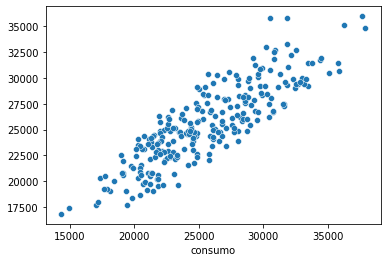

In [138]:
ax = sns.scatterplot(y_train, y_pred_train)

It seems that, as $y$ increases, our prediction gets worse. To improve our visualization, let's draw a line for $\hat{y} = y$

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


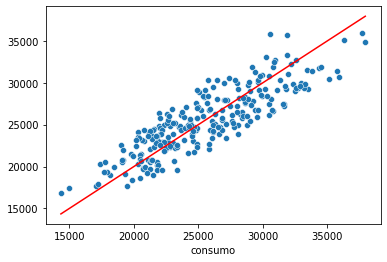

In [139]:
y_draw = np.linspace(y_train.min( ), y_train.max( ), num = 2)

ax = sns.scatterplot(y_train, y_pred_train)
sns.lineplot(y_draw, y_draw, color = 'red')

We can also try to visualize the model residuals. These are found by taking the difference between the model prediction and the true response.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


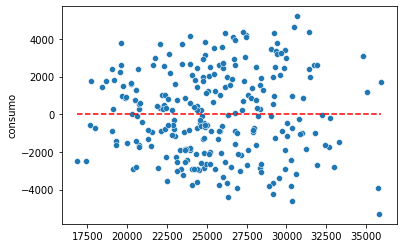

In [140]:
u = y_train - y_pred_train

ax = sns.scatterplot(y_pred_train, u)
ax.hlines(y = 0, xmin = y_pred_train.min( ), xmax = y_pred_train.max( ), color = 'red', linestyles = 'dashed')

This graph is important for us to understand if our residual present homoscedasticity, there is, if the variance for the residuals is constant. This actually does not seem to be the case, since our variance seems to increase as we increase *y_pred_train*. This can be due to the low number of observations. We can see the lack of homocedasticity when we look at the scatterplot for the square residuals:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


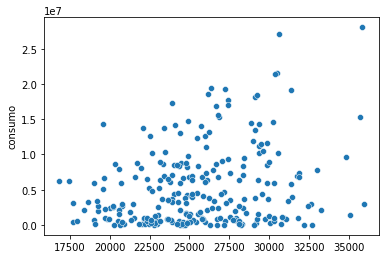

In [141]:
ax = sns.scatterplot(y_pred_train, u*u)

Here, it becomes more clear that, as we increase the prediction, the variance also increases.


These also mean that our residuals may not be drawn from a Normal distribution. Let's draw a histogram:

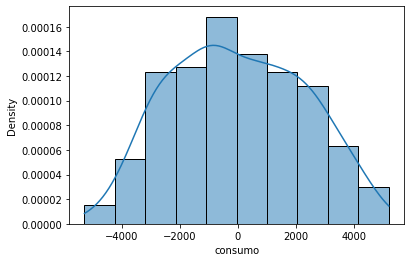

In [142]:
sns.histplot(u, stat = 'density', kde = True)

Indeed, our distribution does not look like a Normal curve. We can also check for the normality of the residuals using a probplot:

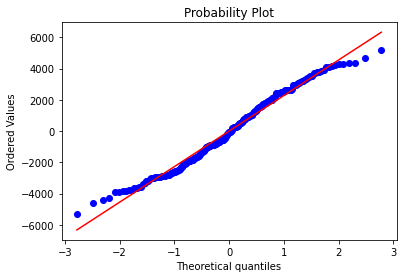

In [143]:
from scipy.stats import probplot
import matplotlib.pyplot as plt

(_, (_, _, _)) = probplot(u, plot = plt)

Finally, we can also try to plot the residuals for different days to check for the homocedasticity:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


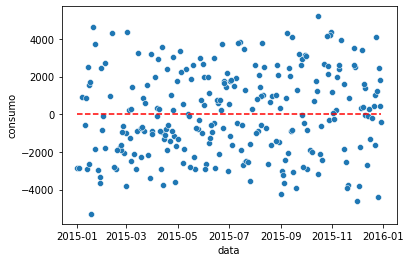

In [144]:
ax = sns.scatterplot(X_train.data, u)
ax.hlines(y = 0, xmin = X_train.data.min( ), xmax = X_train.data.max( ), color = 'red', linestyles = 'dashed')

It seems that, in the year extremes, variance of the residuals is actually higher! This is likely related to the previous result, since we saw that, in the year extremes, there is a higher beer consumption.

# Comparing different models

Usually, we want to explain a dependent variable using a set of independent variables. However, sometimes, using some features in our model may make it worse. There are some methods to compare different models in order to define which is the best one to make predictions.

For instance, let's create two models: one using the maximum temperature, and other using the average temperature:

In [145]:
model1 = LinearRegression( )
model1.fit(X_train[['temp_max', 'chuva', 'fds']], y_train)

model2 = LinearRegression( )
model2.fit(X_train[['temp_media', 'chuva', 'fds']], y_train)

LinearRegression()

Nice! Now, let's use some metrics to compare our two models. First, we can check the determination coefficient of each model:

In [146]:
model1.score(X_train[['temp_max', 'chuva', 'fds']], y_train).round(2)

0.74

In [147]:
model2.score(X_train[['temp_media', 'chuva', 'fds']], y_train).round(2)

0.66

We see that the $R^2$ for model 1, using the maximum temperature, is 0.74, while for model 2 it is 0.66. Thus, according to the $R^2$, model 1 has a better fit to the training set.

Now, let's compare how the prediction and the true values are associated. We can do:

In [148]:
y_pred_1 = model1.predict(X_test[['temp_max', 'chuva', 'fds']])
y_pred_2 = model2.predict(X_test[['temp_media', 'chuva', 'fds']])

In [149]:
metrics.r2_score(y_pred_1, y_test).round(2)

0.62

In [150]:
metrics.r2_score(y_pred_2, y_test).round(2)

0.55

Again, model 1 seems to provide the best fit!

Another interest metric is the Mean Squared Error. This is given by taking the mean of the squared differences between the predicted $y$ and the true values for $y$. Since the unit for the Mean Squared Error is not the same unit from $y$ itself, we usually use the Root Mean Squared Error, where we take the square root of the MSE. Let's use those metrics:

In [151]:
metrics.mean_squared_error(y_pred_1, y_test).round(2)

5873736.08

In [152]:
metrics.mean_squared_error(y_pred_2, y_test).round(2)

5892318.95

Note that the Mean Squared Error for model 2 is slightly higher than the one found for model 1! We can also see this difference in the Root Mean Squared Error:

In [153]:
metrics.mean_squared_error(y_pred_1, y_test, squared = False).round(2)

2423.58

In [154]:
metrics.mean_squared_error(y_pred_2, y_test, squared = False).round(2)

2427.41

Thus, since the error for model 2 is higher, we can say that model 1 best fits the data. To improve our visualization, let's create a table with multiple metrics:

In [155]:
R2_1   = metrics.r2_score(y_pred_1, y_test).round(2)
MSE_1  = metrics.mean_squared_error(y_pred_1, y_test).round(2)
RMSE_1 = metrics.mean_squared_error(y_pred_1, y_test, squared = False).round(2)

R2_2   = metrics.r2_score(y_pred_2, y_test).round(2)
MSE_2  = metrics.mean_squared_error(y_pred_2, y_test).round(2)
RMSE_2 = metrics.mean_squared_error(y_pred_2, y_test, squared = False).round(2)

metrics_dict = {"Model 1" : [R2_1, MSE_1, RMSE_1],
                "Model 2" : [R2_2, MSE_2, RMSE_2]}

TabMetrics = pd.DataFrame(metrics_dict, index = ['R2', 'MSE', 'RMSE'])
TabMetrics

,Model 1,Model 2
R2,0.62,0.55
MSE,5873736.08,5892318.95
RMSE,2423.58,2427.41


**Note that, as we increase the number of features, the $R^2$ ALWAYS increases. In these cases, we should use other metrics, such as the RMSE or the adjusted $R^2$**

# Saving our model

When we work on different projects, we might want to save our model, so that we don't have to train our model again. Sometimes, training our model may take minutes, hours, or even days. Thus, we can save our model parameters and, later, we can simply call these parameters using the model equation to perform a prediction.

For model 1, we have the following parameters:

In [156]:
betas_df

,Params
Intercept,5549.848551
Max temp.,701.323298
Precipitation,-56.879669
Weekend,5302.570916


To save these, we can use the pickle library. This library implements binary protocols to serialize and de-serialize a Python object. 

In [157]:
import pickle

output = open('model1_linreg_beer', 'wb')
pickle.dump( model1, output )
output.close( )

When we do this, we create a file "model_linreg_beer" in our local folder. To open this model on a different project, we can do:

In [158]:
import pickle

model_old = open('model1_linreg_beer', 'rb')
lm_new = pickle.load(model_old)
model_old.close( )

Note that here we used method *rb*, which means read binary, while previously we used *wb*, which means write binary. Now, let's test our model:

In [159]:
temp_max = 30.5
precipt  = 12.2
fds = 0

data_entry = [temp_max, precipt, fds]
lm_new.predict([data_entry])[0]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


26246.27717479485

Nice! Note that the result found is the same as the one found using our old model:

In [160]:
model1.predict([data_entry])[0]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


26246.27717479485

# More applications

Here, we will show another example of how linear regression can be used to perform accurate predictions in our dataset. This time, we will use another dataset from Kaggle. The dataset has one dependent variable, which is the house price, and multiple independet variables:

* Area
* Number of vehicle spots
* Number of bathrooms
* Number of fireplaces
* If there is a marble finish (boolean)
* If there is more than one floor (boolean)

First, let's take a look at our dataset:




In [161]:
prices = pd.read_csv('HousePrices_HalfMil.csv', sep = ';')
prices

,precos,area,garagem,banheiros,lareira,marmore,andares
0,51875,25,3,4,3,0,1
1,17875,35,1,3,1,0,0
2,47075,195,2,4,2,0,0
3,38575,33,2,2,1,0,1
4,33775,11,2,3,0,0,1
...,...,...,...,...,...,...,...
995,29150,48,1,5,4,0,0
996,43550,112,2,2,3,0,1
997,56575,185,3,4,4,0,1
998,56075,185,2,3,1,0,1


Our dataset has 1000 entries and 7 features.

In [162]:
prices.info( )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   precos     1000 non-null   int64
 1   area       1000 non-null   int64
 2   garagem    1000 non-null   int64
 3   banheiros  1000 non-null   int64
 4   lareira    1000 non-null   int64
 5   marmore    1000 non-null   int64
 6   andares    1000 non-null   int64
dtypes: int64(7)
memory usage: 54.8 KB


Also, there are no null entries, and all features have an integer datatype. Let's visualize our data. First, let's study our dependent variable:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


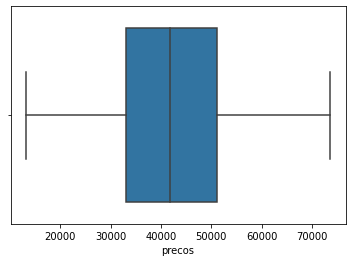

In [163]:
sns.boxplot(prices.precos)

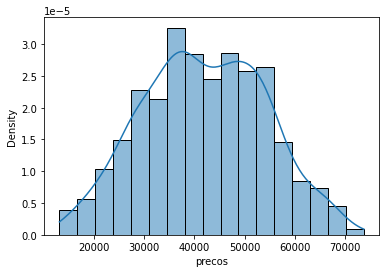

In [164]:
sns.histplot(prices.precos, kde = True, stat = 'density')

We see that the housing prices does not follow a Normal distribution. However, it seems to present an almost symmetric distribution. We can check this using more formal tests, such as a normal test and using a QQPlot.

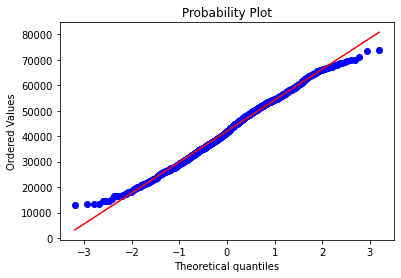

In [165]:
(_, (_, _, _)) = probplot(prices.precos, plot = plt)

In [166]:
from scipy.stats import normaltest

normaltest(prices.precos)

NormaltestResult(statistic=27.140991071026622, pvalue=1.2776405063525777e-06)

Since our p-value is lower than the test significance (considered here to be 5%), we reject the null hypothesis that the data is drawn from a normal distribution.

Let's try to visualize how the dependent variable is related to the independent variables. First, does the house area influences in the price:

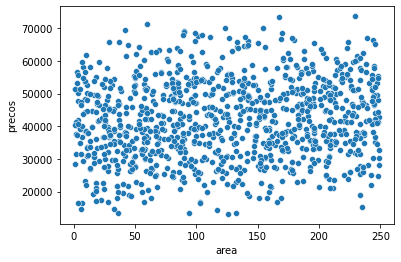

In [167]:
sns.scatterplot(x = 'area', y = 'precos', data = prices)

It seems that there is no clear relation between area and price. Now, let's see if prices for house with more than one floor usually have higher prices:

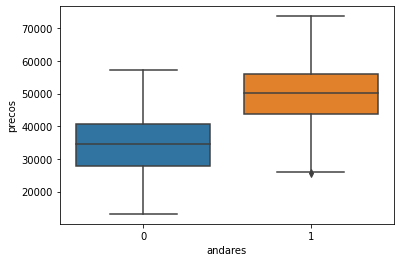

In [168]:
sns.boxplot(x = 'andares', y = 'precos', data = prices)

It seems that, when houses have more than one floor, house prices tend to be higher!

We can add a new feature to the boxplot using the hue parameter:

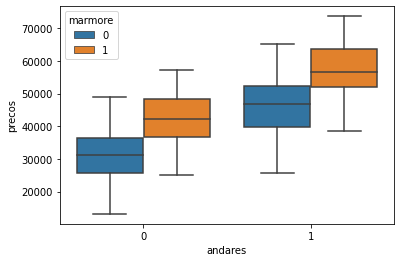

In [169]:
sns.boxplot(x = 'andares', y = 'precos', hue = 'marmore', data = prices)

Again, it seems that, when we use a marble finish, house prices are actually higher. 

Let's create boxplots to show how prices change for different number of bathrooms and garaga spots:

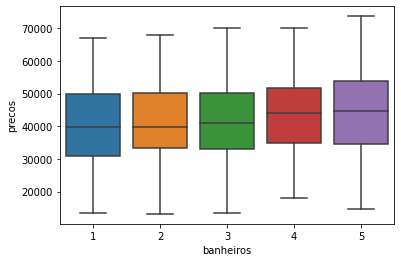

In [170]:
sns.boxplot(x = 'banheiros', y = 'precos', data = prices)

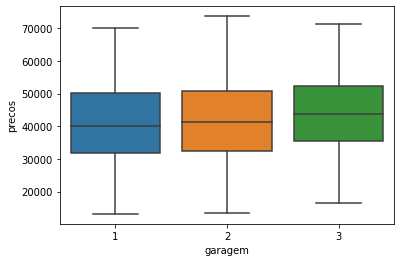

In [171]:
sns.boxplot(x = 'garagem', y = 'precos', data = prices)

It seems that, when we increase the number of garage spots, we increase the housing prices!

Let's plot a pairplot to see how all features are related to the dependent variable:

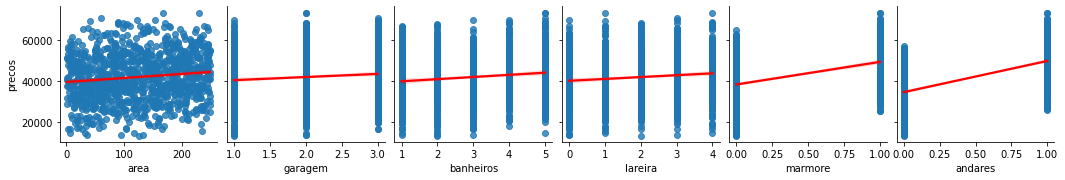

In [172]:
ax = sns.pairplot(data = prices, y_vars = ['precos'], x_vars = ['area', 'garagem', 'banheiros', 'lareira', 'marmore', 'andares'], kind = 'reg', plot_kws={'line_kws':{'color':'red'}})

Finally, let's draw a correlation matrix for the data:

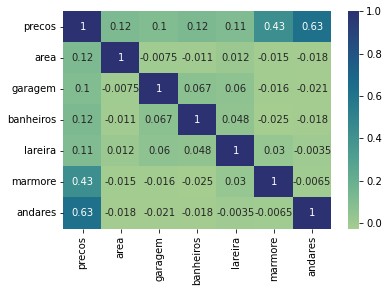

In [173]:
sns.heatmap(prices.corr( ), annot = True, cmap = 'crest')

We see that there the 'precos' column has a high correlation with features 'marmore' and 'andares'. All other features seems to present a very low correlation.

Since our dependent features present a very low correlation with each other, our model will use all features. Thus, lets create our model.

First, let's make the train-test split:

In [174]:
X = prices.drop('precos', axis = 1)
y = prices.precos

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Now, let's fit our model:

In [175]:
model_prices = LinearRegression( )
model_prices.fit(X_train, y_train)

LinearRegression()

Finally, let's evaluate some metrics. First, let's get the $R^2$ score:

In [176]:
model_prices.score(X_train, y_train).round(2)

0.66

So, our model presents a determination coefficient of 0.64. Let's get the determination coefficient for the prediction x test set:

In [177]:
y_pred = model_prices.predict(X_test)

metrics.r2_score(y_test, y_pred).round(2)

0.59

Our determination coefficent is actually higher when we use the test set. Finally, let's evaluate the MSE and the RMSE:

In [178]:
metrics.mean_squared_error(y_test, y_pred).round(2)

55616207.71

In [179]:
metrics.mean_squared_error(y_test, y_pred, squared = False).round(2)

7457.63

Nice! If we build another model, we can use these metrics to compare if it is better or worse than our model!

To finish our new application, let's save our model using pickle:

In [180]:
import pickle

output = open('model_new', 'wb')
pickle.dump( model_prices, output )
output.close( )

Nice! Now, we can use our model for future applications. To load it, we can simply use:

In [181]:
model_old = open('model_new', 'rb')
lm_new = pickle.load(model_old)
model_old.close( )

## Extra: Interactive simulator

Using Python, we can create an interactive simulator to help us in the passing of features to predict a given result. For that end, we have to import some libraries to handle python widgets and display:

In [182]:
from ipywidgets import widgets, HBox, VBox
from IPython.display import display

area      = widgets.Text(description = 'Area')
garage    = widgets.Text(description = 'Num. garage spots')
bathroom  = widgets.Text(description = 'Num. bathrooms')
fireplace = widgets.Text(description = 'Num. fireplaces')
marble    = widgets.Text(description = 'Marble finish?')
floor     = widgets.Text(description = 'More than one floor?')

button = widgets.Button(description = 'Predict')

left  = VBox([area, garage, bathroom])
right = VBox([fireplace, marble, floor])
inputs = HBox([left, right])

Now, let's create our simulator:

In [183]:
def simulate(sender):
  entry = [[
            float(area.value if area.value else 0),
            float(garage.value if garage.value else 0),
            float(bathroom.value if bathroom.value else 0),
            float(fireplace.value if fireplace.value else 0),
            float(marble.value if marble.value else 0),
            float(floor.value if floor.value else 0)
  ]]

  print(f'Prediction: R$ {lm_new.predict(entry)[0].round(2)}')

Now, let's make it so that, when we click our button, we run the simulator:

In [184]:
button.on_click(simulate)

Great! Now, to run our simulator, we can simply do:

In [185]:
display(inputs, button)

Button(description='Predict', style=ButtonStyle())

Prediction: R$ 36385.09


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"
